#  Прогнозирование заказов такси

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Цель: Построить модель для предсказания количества заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


## Подготовка

In [1]:
# импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
import lightgbm as lgb


import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
# чтение файла с данными и сохранение 
try: data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0]) 
except: data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# просмотрим первые строки
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# просмотрим информацию 
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# Проверим, что индекс монотонный
data.index.is_monotonic

True

In [6]:
# ресемплинг - среднее по каждому часу
data = data.resample('1H').sum()

## Анализ

<AxesSubplot:xlabel='datetime'>

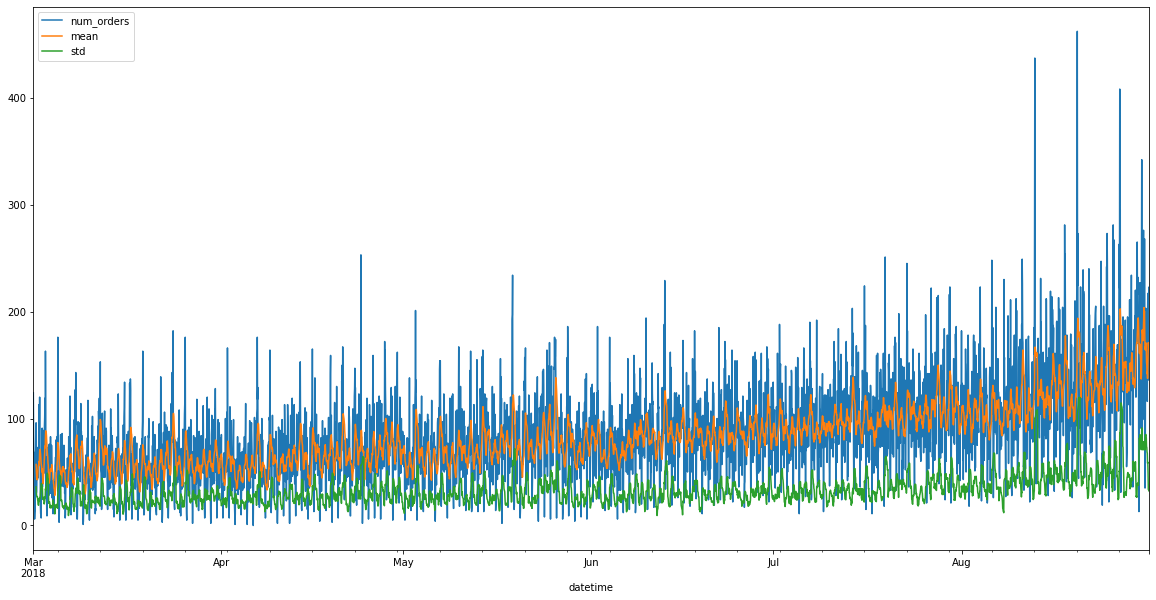

In [7]:
# Добавим признак скользящего среднего и стандартного отклонения
data['mean'] = data['num_orders'].rolling(12).mean()
data['std'] = data['num_orders'].rolling(12).std()
data.plot(figsize=(20, 10)) 

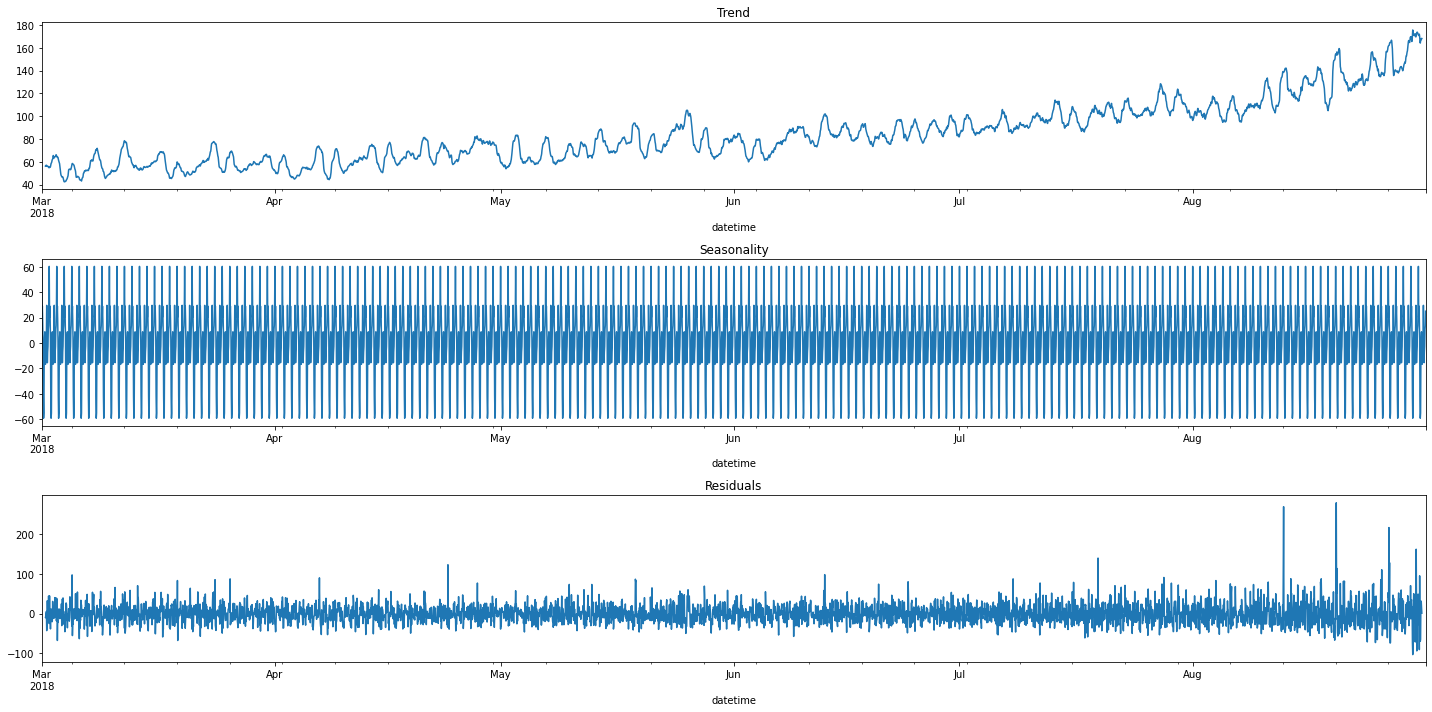

In [8]:
# разложим временной ряд на тренд, сезонность и остаток

decomposed = seasonal_decompose(data['num_orders']) # < напишите код здесь >

plt.figure(figsize=(20, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [9]:
# добавим календарные признаки и отстающее значение 
def make_features(data, max_lag, rolling_mean_size):

    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)



make_features(data, 8, 8)

<AxesSubplot:xlabel='hour'>

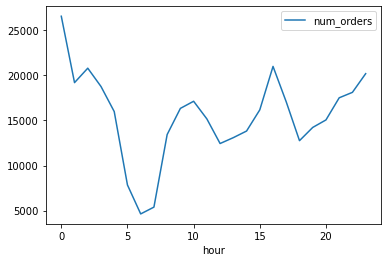

In [10]:
# посмотрим как время повлияло на количество
data.pivot_table(index = ['hour'], values = 'num_orders', aggfunc = 'sum').plot()

### Вывод

Изучаемые данные представляют собой нестационарные ряды: меняется среднее значение и стандартное отклонение. 

Данные имеют восходящий тренд и сезонную составляющую, можно отметить увеличение в летние месяцы. Кроме того, на графике видно, что в 6-7 утра заказов меньше, а около полуночи больше.

## Обучение

In [11]:
# разобъем выборку и удалим пропуски
train_valid, test = train_test_split(data, shuffle=False, test_size=0.1)
train_valid = train_valid.dropna()
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.2)

features_train = train.drop('num_orders', axis = 1)
features_valid = valid.drop('num_orders', axis = 1)
features_test = test.drop('num_orders', axis = 1)

target_train = train['num_orders']
target_valid = valid['num_orders']
target_test = test['num_orders']

print(features_train.shape, features_valid.shape, features_test.shape)
print(target_train.shape, target_valid.shape, target_test.shape)

(3170, 13) (793, 13) (442, 13)
(3170,) (793,) (442,)


In [12]:
# Линейная регрессия
model = LinearRegression()
model.fit(features_train, target_train)
pred = model.predict(features_valid)

RMSE = mean_squared_error(target_valid, pred, squared=False)
RMSE

35.37953976967459

In [13]:
# Дерево решений (переберем глубину)

best_model = None
best_result = 100
best_depth = 0


for i in range(1, 10):
    model = DecisionTreeRegressor(max_depth=i, random_state=12345)
    model.fit(features_train, target_train)
    pred = model.predict(features_valid)
    RMSE = mean_squared_error(target_valid, pred, squared=False)

    if RMSE < best_result:
        best_model = model
        best_result = RMSE
        best_depth = i

print(best_result, i)



37.44555410436448 9


In [14]:
# Случайный лес в регрессии (переберем глубину, количество деревьев)

best_model = None
best_result = 100
best_est = 0
best_depth = 0
best_i = 0
for est in range(1, 10):
    for depth in range (3, 7):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train)
        pred = model.predict(features_valid)
        RMSE = mean_squared_error(target_valid, pred, squared=False)
        if RMSE < best_result:
            best_model = model
            best_result = RMSE
            best_est = est
            best_depth = depth


print((best_result), best_est, best_depth)

35.52140360200168 9 6


In [15]:
# Градиентный бустинг LightGBM
list_rmse = []
list_i = []
list_depth = []
for i in range(1, 10):
    for depth in range(1,10):
# создадим модель 
        model = lgb.LGBMModel(objective="regression", n_estimators=20,  learning_rate=(i/10), max_depth=depth)
# обучим модель 
        model.fit(features_train, target_train, eval_set=[(features_valid, target_valid),], eval_metric="rmse")
        preds = model.predict(features_valid)
        RMSE = mean_squared_error(target_valid, preds, squared=False)
        list_rmse.append(RMSE)
        list_i.append(i)
        list_depth.append(depth)
        
# создадим датафрейм с rmse
rmse_data = pd.DataFrame(columns = ['rmse', 'i', 'depth'])
rmse_data['rmse'] = list_rmse
rmse_data['i'] = list_i
rmse_data['depth'] = list_depth

# найдем наименьший
rmse_data.sort_values('rmse').head(1)

[1]	valid_0's rmse: 54.2973	valid_0's l2: 2948.2
[2]	valid_0's rmse: 53.7383	valid_0's l2: 2887.81
[3]	valid_0's rmse: 53.0623	valid_0's l2: 2815.61
[4]	valid_0's rmse: 52.7188	valid_0's l2: 2779.28
[5]	valid_0's rmse: 51.999	valid_0's l2: 2703.89
[6]	valid_0's rmse: 51.2411	valid_0's l2: 2625.65
[7]	valid_0's rmse: 50.959	valid_0's l2: 2596.82
[8]	valid_0's rmse: 50.6851	valid_0's l2: 2568.98
[9]	valid_0's rmse: 50.0135	valid_0's l2: 2501.35
[10]	valid_0's rmse: 49.7773	valid_0's l2: 2477.78
[11]	valid_0's rmse: 49.6	valid_0's l2: 2460.16
[12]	valid_0's rmse: 49.0285	valid_0's l2: 2403.8
[13]	valid_0's rmse: 48.7488	valid_0's l2: 2376.44
[14]	valid_0's rmse: 48.2749	valid_0's l2: 2330.46
[15]	valid_0's rmse: 48.1304	valid_0's l2: 2316.54
[16]	valid_0's rmse: 47.9495	valid_0's l2: 2299.16
[17]	valid_0's rmse: 47.3321	valid_0's l2: 2240.33
[18]	valid_0's rmse: 47.177	valid_0's l2: 2225.67
[19]	valid_0's rmse: 47.0245	valid_0's l2: 2211.31
[20]	valid_0's rmse: 46.6688	valid_0's l2: 2177.

,rmse,i,depth
57,30.23,7,4


### Вывод

Наилучший резултат (меньший) метрики RMSE равен 35,26 у модели линейной регрессии. Кроме того, были опробованы модели Дерево решений, Случайный лес в регрессии и Градиентный бустинг LightGBM (RMSE в диапазоне 36,9 - 41).

## Тестирование

In [16]:
# объеденим выборку train и valid, тк тестовая должна быть строго после, без разрывов
features_train_valid = train_valid.drop('num_orders', axis = 1)
target_train_valid = train_valid['num_orders']

In [25]:
# Линейная регрессия
model = LinearRegression()
model.fit(features_train_valid, target_train_valid)
pred = model.predict(features_test)

RMSE = mean_squared_error(target_test, pred, squared=False)
RMSE

46.828450862546646

In [18]:
# Дерево решений
model = DecisionTreeRegressor(max_depth=9, random_state=12345)
model.fit(features_train_valid, target_train_valid)
pred = model.predict(features_test)
RMSE = mean_squared_error(target_test, pred, squared=False)
RMSE

55.65493887931869

In [24]:
# Случайный лес в регрессии 
model = RandomForestRegressor(random_state=12345, n_estimators=9, max_depth=6) 
model.fit(features_train_valid, target_train_valid)
pred = model.predict(features_test)
RMSE = mean_squared_error(target_test, pred, squared=False)
RMSE

44.2403681382849

In [22]:
# Градиентный бустинг LightGBM
model = lgb.LGBMModel(objective="regression", n_estimators=20,  learning_rate=(7/10), max_depth=4)
model.fit(features_train_valid, target_train_valid, eval_set=[(features_test, target_test),], eval_metric="rmse")
preds = model.predict(features_test)
RMSE = mean_squared_error(target_test, preds, squared=False)
RMSE

[1]	valid_0's rmse: 60.2425	valid_0's l2: 3629.15
[2]	valid_0's rmse: 54.0594	valid_0's l2: 2922.42
[3]	valid_0's rmse: 50.6596	valid_0's l2: 2566.4
[4]	valid_0's rmse: 49.1972	valid_0's l2: 2420.36
[5]	valid_0's rmse: 46.1658	valid_0's l2: 2131.28
[6]	valid_0's rmse: 46.38	valid_0's l2: 2151.1
[7]	valid_0's rmse: 46.1486	valid_0's l2: 2129.69
[8]	valid_0's rmse: 46.8143	valid_0's l2: 2191.58
[9]	valid_0's rmse: 45.6117	valid_0's l2: 2080.43
[10]	valid_0's rmse: 44.2052	valid_0's l2: 1954.1
[11]	valid_0's rmse: 44.0709	valid_0's l2: 1942.24
[12]	valid_0's rmse: 43.6701	valid_0's l2: 1907.08
[13]	valid_0's rmse: 44.3146	valid_0's l2: 1963.79
[14]	valid_0's rmse: 43.8787	valid_0's l2: 1925.34
[15]	valid_0's rmse: 43.9924	valid_0's l2: 1935.33
[16]	valid_0's rmse: 43.9064	valid_0's l2: 1927.77
[17]	valid_0's rmse: 43.4635	valid_0's l2: 1889.08
[18]	valid_0's rmse: 43.7917	valid_0's l2: 1917.71
[19]	valid_0's rmse: 43.5663	valid_0's l2: 1898.02
[20]	valid_0's rmse: 43.8122	valid_0's l2: 19

43.812196587241125

In [23]:
# проверим какой результат покажет DummyRegressor

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
predict_dummy = dummy_regr.predict(features_test)

RMSE = mean_squared_error(target_test, predict_dummy, squared=False)
RMSE

89.91514205272647

In [37]:
preds = pd.DataFrame(preds, index = target_test.index)

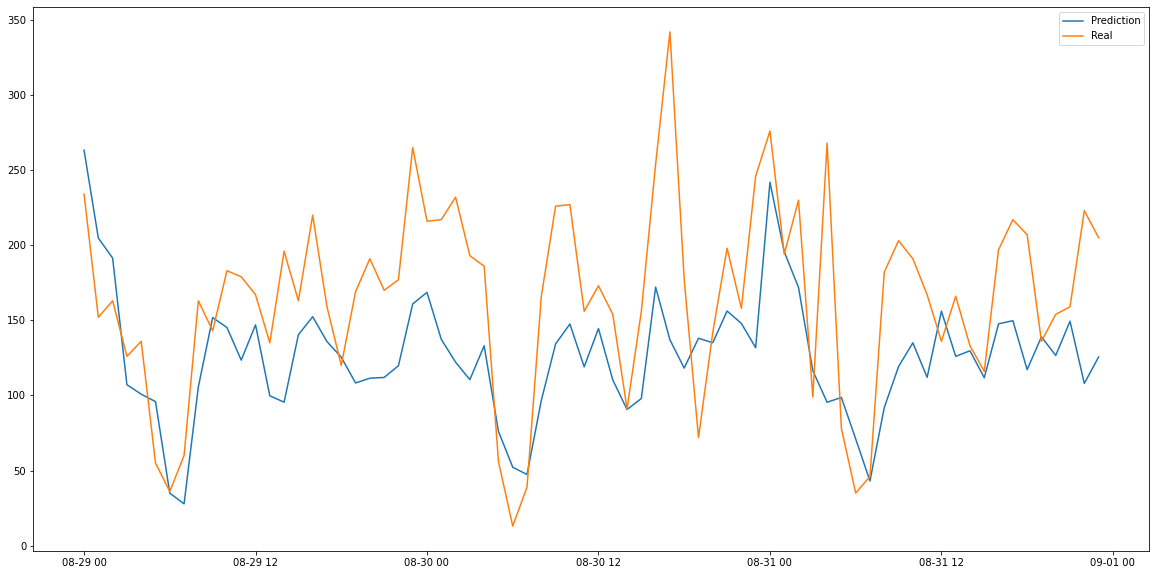

In [70]:

plt.figure(figsize=(20, 10))
plt.plot(preds.loc['2018-08-29':'2018-08-31'], label = 'Prediction')
plt.plot(target_test.loc['2018-08-29':'2018-08-31'], label = 'Real')
plt.legend()


### Вывод

По итогам оценки на адекватность видно, что базовая модель (DummyRegressor) показывает слабые результаты 89,9. В этой связи проверку на адекватность рассмотренные выше модели прошли.

Тестирование моделей показало, что модель Градиентный бустинг LightGBM готовит лучше результаты и на тестовой выборке (RMSE = 43.8). модель Случайный лес в регрессии имеет близкий результат RMSE = 44.2.

На графике можно визуально сопоставить предсказания с реальными данными за последние 3 дня. В целом предсказанные данные Соответствуют колебаниям графика с реальными данными, но пиковые значения не полностью покрываются.